In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

DATASET_PATH = '/content/drive/MyDrive/PBL 2/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'


In [ ]:
pip install tensorflow matplotlib scikit-learn opencv-python


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")


In [ ]:
DATASET_PATH = '/content/drive/MyDrive/PBL 2/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
CLASSES = ['Normal', 'Cyst', 'Tumor', 'Stone']
IMG_SIZE = 150  # You can change to 224 if using pretrained models

images = []
labels = []

for label in CLASSES:
    folder_path = os.path.join(DATASET_PATH, label)
    for img_name in tqdm(os.listdir(folder_path), desc=f'Loading {label}'):
        try:
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(label)
        except:
            continue

X = np.array(images)
y = np.array(labels)
print("Dataset loaded:", X.shape, len(y))


Loading Stone: 100%|██████████| 107/107 [00:01<00:00, 69.13it/s]


Dataset loaded: (508, 150, 150, 3) 508


In [ ]:
X = X / 255.0  # Normalize pixel values between 0 and 1


In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Class mapping: {np.str_('Cyst'): np.int64(0), np.str_('Normal'): np.int64(1), np.str_('Stone'): np.int64(2), np.str_('Tumor'): np.int64(3)}


In [ ]:
from collections import Counter
print("Original Class Distribution:", Counter(y_encoded))


Original Class Distribution: Counter({np.int64(3): 210, np.int64(2): 107, np.int64(1): 101, np.int64(0): 90})


In [ ]:
from sklearn.utils import resample

def balance_data(X, y):
    df = pd.DataFrame({'label': y})
    max_count = df['label'].value_counts().max()

    X_balanced = []
    y_balanced = []

    for class_idx in np.unique(y):
        X_class = X[y == class_idx]
        y_class = y[y == class_idx]
        X_resampled, y_resampled = resample(
            X_class,
            y_class,
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        X_balanced.extend(X_resampled)
        y_balanced.extend(y_resampled)

    return np.array(X_balanced), np.array(y_balanced)

X, y_encoded = balance_data(X, y_encoded)
print("Balanced class counts:", Counter(y_encoded))


Balanced class counts: Counter({np.int64(0): 210, np.int64(1): 210, np.int64(2): 210, np.int64(3): 210})


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (672, 150, 150, 3) Val: (168, 150, 150, 3)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_aug = ImageDataGenerator(
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_aug = ImageDataGenerator()  # No augmentation for validation


In [ ]:
def add_edge_features(X):
    edge_images = []
    for img in X:
        gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
        edge = cv2.Canny(gray, 100, 200)
        edge = edge / 255.0
        edge = np.expand_dims(edge, axis=-1)
        edge_images.append(edge)
    edge_images = np.array(edge_images)
    return np.concatenate([X, edge_images], axis=-1)  # new shape: (H, W, 4)

X_train = add_edge_features(X_train)
X_val = add_edge_features(X_val)
print("New input shape with edge feature:", X_train.shape)


New input shape with edge feature: (672, 150, 150, 4)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

input_shape = X_train.shape[1:]  # e.g., (150, 150, 4)

model_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,830,052 (18.43 MB)

 Trainable params: 4,829,604 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_cnn = model_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.6372 - loss: 4.0171 - val_accuracy: 0.2500 - val_loss: 9.5755
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.9537 - loss: 0.2128 - val_accuracy: 0.2500 - val_loss: 33.5063
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9685 - loss: 0.1144 - val_accuracy: 0.2500 - val_loss: 38.6977
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.9622 - loss: 0.1547 - val_accuracy: 0.2500 - val_loss: 36.8147
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9845 - loss: 0.0329 - val_accuracy: 0.2500 - val_loss: 34.9393
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9838 - loss: 0.0461 - val_accuracy: 0.3274 - val_loss: 30.2491


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze feature extractor

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=output)
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_vgg.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history_vgg = model_vgg.fit(
    X_train[:,:,:,:3],  # Remove edge channel for VGG
    y_train,
    validation_data=(X_val[:,:,:,:3], y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 188s 9s/step - accuracy: 0.3973 - loss: 1.2965 - val_accuracy: 0.5655 - val_loss: 0.9936
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 190s 9s/step - accuracy: 0.6561 - loss: 0.9084 - val_accuracy: 0.6964 - val_loss: 0.7985
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 191s 9s/step - accuracy: 0.7538 - loss: 0.7318 - val_accuracy: 0.8095 - val_loss: 0.6390
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 201s 9s/step - accuracy: 0.8059 - loss: 0.5989 - val_accuracy: 0.8274 - val_loss: 0.5407
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 201s 9s/step - accuracy: 0.8666 - loss: 0.4992 - val_accuracy: 0.9286 - val_loss: 0.4437
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 210s 10s/step - accuracy: 0.9028 - loss: 0.4029 - val_accuracy: 0.9286 - val_loss: 0.3697
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 192s 9s/step - accuracy: 0.9443 - loss: 0.3287 - val_accuracy: 0.9286 - val_loss: 0.3115
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 202s 9s/step - accuracy: 0.9283 - loss: 0.3318 - val_accuracy: 0.9345 - 

In [ ]:
def get_gradcam_heatmap(model, image, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs],
                                       [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
def display_gradcam(image, label_index, model, last_conv_layer):
    # Check if the model is VGG and slice the image accordingly
    if model.name.startswith('functional'): # Assuming VGG is 'functional' based on model.summary()
        heatmap = get_gradcam_heatmap(model, image[:,:,:3], last_conv_layer)
    else:
        heatmap = get_gradcam_heatmap(model, image, last_conv_layer)

    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    image_rgb = (image[:,:,:3] * 255).astype("uint8")
    superimposed_img = cv2.addWeighted(image_rgb, 0.6, heatmap_color, 0.4, 0)

    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM - Predicted: {le.inverse_transform([label_index])[0]}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


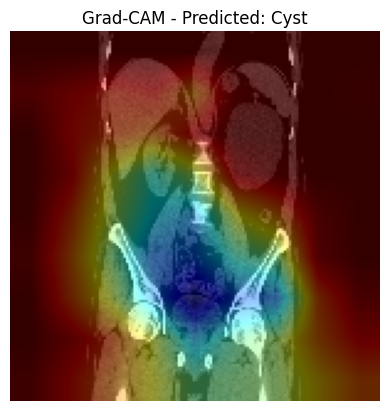

In [ ]:
sample_img = X_val[0]
pred = model_vgg.predict(np.expand_dims(sample_img[:,:,:3], axis=0))
display_gradcam(sample_img, np.argmax(pred), model_vgg, 'block5_conv3')  # For VGG


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step
              precision    recall  f1-score     support
Cyst           1.000000  0.833333  0.909091   42.000000
Normal         1.000000  1.000000  1.000000   42.000000
Stone          0.976744  1.000000  0.988235   42.000000
Tumor          0.854167  0.976190  0.911111   42.000000
accuracy       0.952381  0.952381  0.952381    0.952381
macro avg      0.957728  0.952381  0.952109  168.000000
weighted avg   0.957728  0.952381  0.952109  168.000000


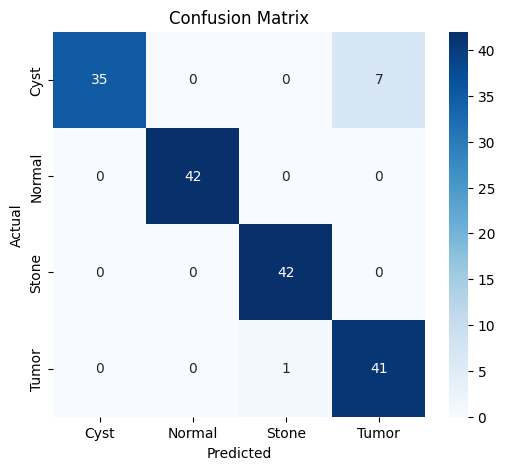

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict
y_pred_prob = model_vgg.predict(X_val[:,:,:,:3])
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification Report
report = classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Display
print(df_report)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


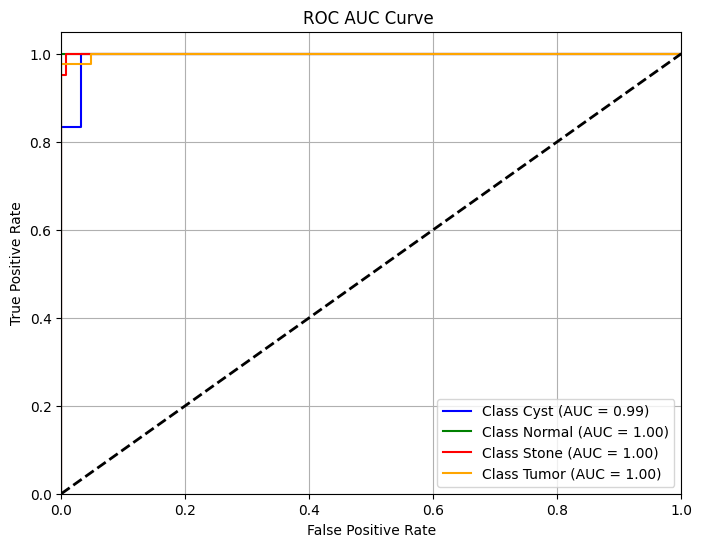

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

# One-hot encode ground truth
y_val_bin = label_binarize(y_val, classes=[0,1,2,3])
n_classes = y_val_bin.shape[1]

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f"Class {le.inverse_transform([i])[0]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve ')
plt.legend(loc='lower right')
plt.grid()
plt.show()


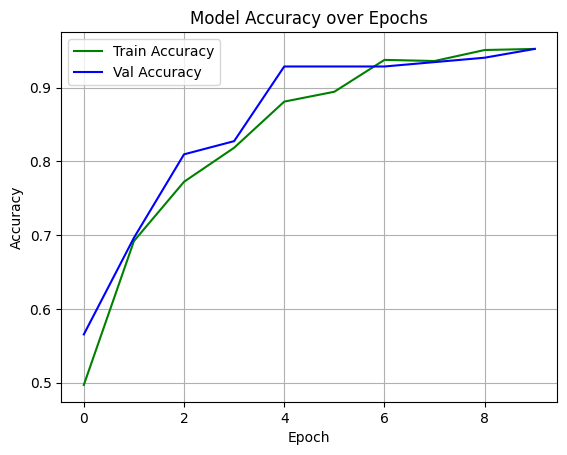

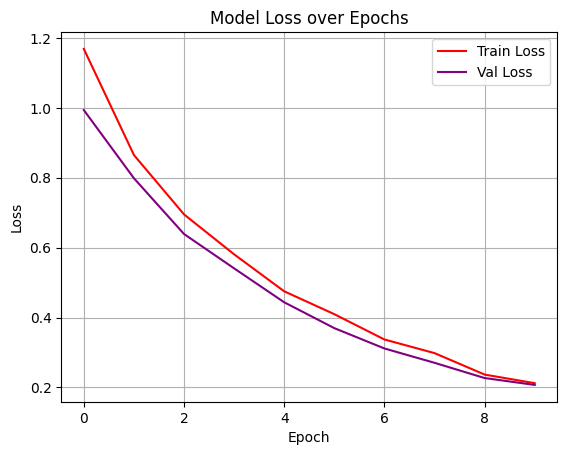

In [ ]:
# Accuracy
plt.plot(history_vgg.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history_vgg.history['val_accuracy'], label='Val Accuracy', color='blue')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_vgg.history['loss'], label='Train Loss', color='red')
plt.plot(history_vgg.history['val_loss'], label='Val Loss', color='purple')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


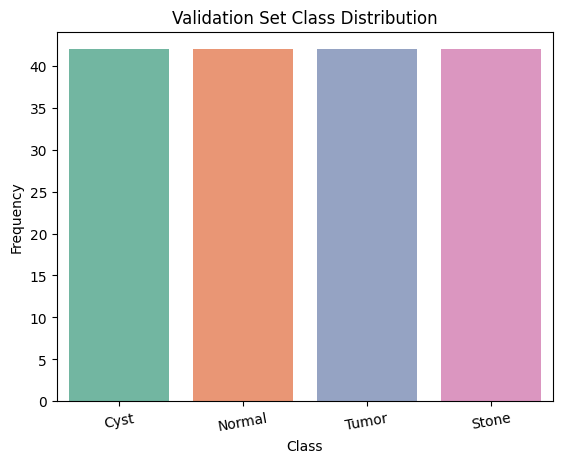

In [ ]:
# Assuming y_raw was original label list before SMOTE
sns.countplot(x=le.inverse_transform(y_val), palette='Set2')
plt.title("Validation Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=10)
plt.show()


In [ ]:
plt.savefig("roc_auc_curve.png", dpi=300, bbox_inches='tight')  # Save any plot


<Figure size 640x480 with 0 Axes>

6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step


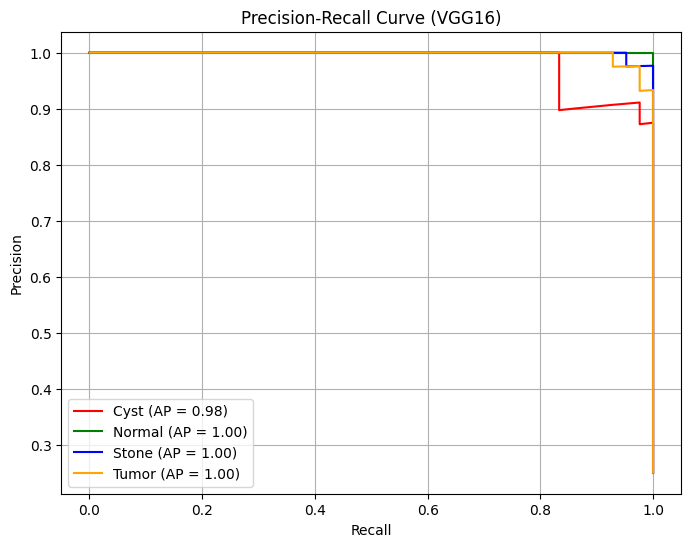

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize labels for PR curve
y_val_bin = label_binarize(y_val, classes=[0, 1, 2, 3])
n_classes = y_val_bin.shape[1]

# Predict probabilities for VGG16 or CNN
y_score_vgg = model_vgg.predict(X_val[:,:,:,:3])
# y_score_cnn = model_cnn.predict(X_val)

# Precision-Recall curve
plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue', 'orange']

for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_val_bin[:, i], y_score_vgg[:, i])
    ap_score = average_precision_score(y_val_bin[:, i], y_score_vgg[:, i])
    plt.plot(recall, precision, color=color, label=f'{le.classes_[i]} (AP = {ap_score:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (VGG16)")
plt.legend(loc='best')
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


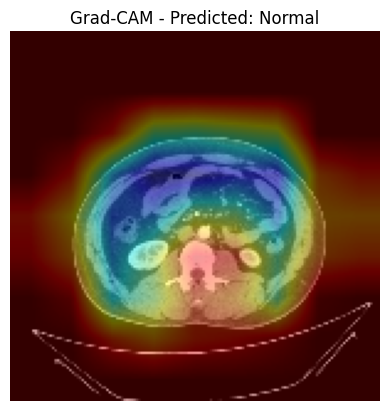

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


AttributeError: The layer sequential has never been called and thus has no defined output.

In [ ]:
indices = [5, 15, 25, 40]  # Pick random indexes from validation set

for idx in indices:
    img_rgb = X_val[idx][:,:,:3]
    img_full = X_val[idx]

    # VGG16 Grad-CAM
    pred = model_vgg.predict(np.expand_dims(img_rgb, axis=0))
    pred_label = np.argmax(pred)
    display_gradcam(img_rgb, pred_label, model_vgg, last_conv_layer='block5_conv3')

    # CNN Grad-CAM
    pred = model_cnn.predict(np.expand_dims(img_full, axis=0))
    pred_label = np.argmax(pred)
    display_gradcam(img_full, pred_label, model_cnn, last_conv_layer='dense_1')  # adjust layer if needed

6/6 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step


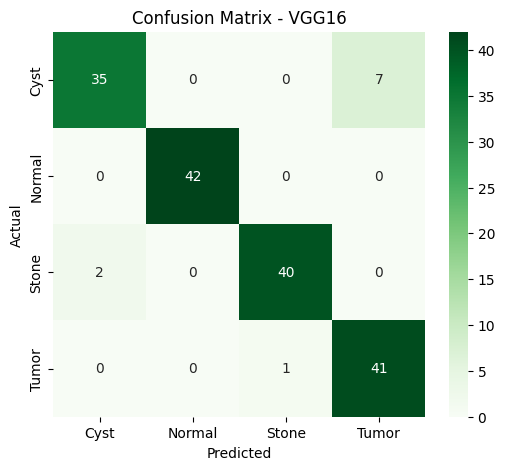

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_vgg = np.argmax(model_vgg.predict(X_val[:,:,:,:3]), axis=1)
cm_vgg = confusion_matrix(y_val, y_pred_vgg)

plt.figure(figsize=(6,5))
sns.heatmap(cm_vgg, annot=True, cmap='Greens', fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - VGG16")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


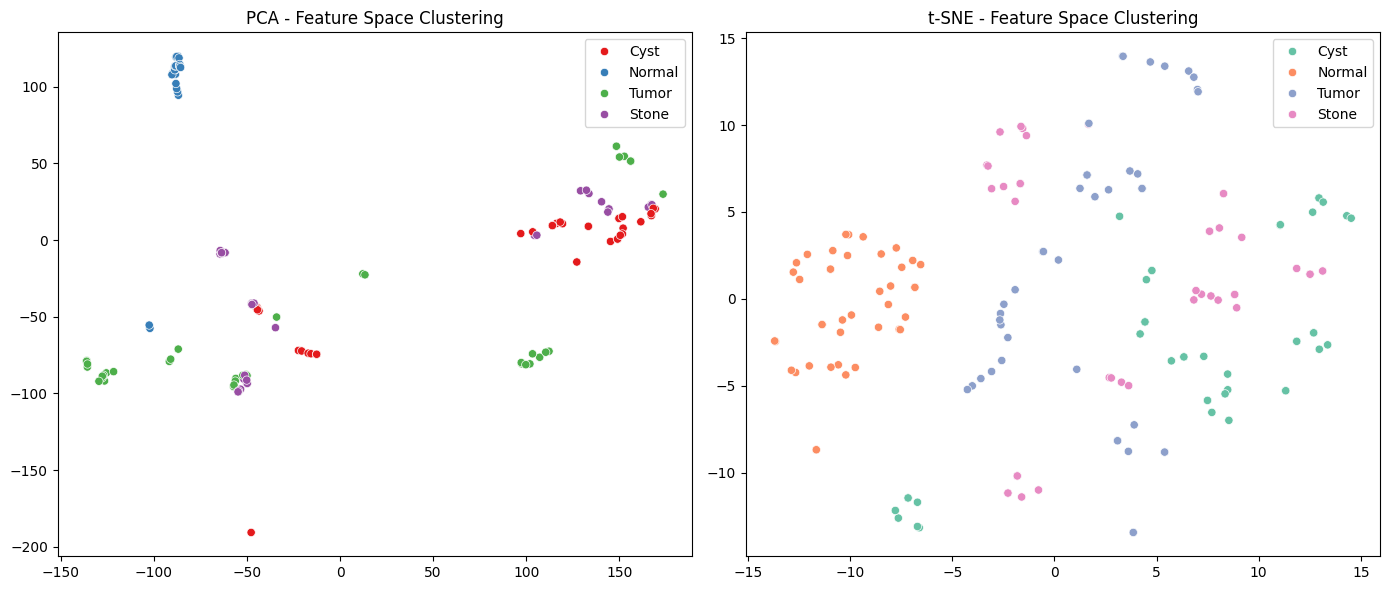

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Flatten features
X_flat = X_val.reshape(X_val.shape[0], -1)  # shape (N, 150*150*4)

# Option 1: PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X_flat))

# Option 2: t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_flat)

# Plot both
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# PCA
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=le.inverse_transform(y_val),
                palette='Set1', ax=axs[0])
axs[0].set_title("PCA - Feature Space Clustering")

# t-SNE
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=le.inverse_transform(y_val),
                palette='Set2', ax=axs[1])
axs[1].set_title("t-SNE - Feature Space Clustering")

plt.tight_layout()
plt.show()


In [ ]:
# Re-run data loading, preprocessing, and splitting cells
# Cell 21A3UrHEZIDL
from google.colab import drive
drive.mount('/content/drive')

# Cell 4fq-7tFrZeJd
import os
DATASET_PATH = '/content/drive/MyDrive/PBL 2/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# Cell HwXacW3QaxlK
# pip install tensorflow matplotlib scikit-learn opencv-python # Already installed

# Cell 44Wosw6SblaG
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

# Cell haBWj_yabp0G
DATASET_PATH = '/content/drive/MyDrive/PBL 2/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
CLASSES = ['Normal', 'Cyst', 'Tumor', 'Stone']
IMG_SIZE = 150

images = []
labels = []

for label in CLASSES:
    folder_path = os.path.join(DATASET_PATH, label)
    for img_name in tqdm(os.listdir(folder_path), desc=f'Loading {label}'):
        try:
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(label)
        except:
            continue

X = np.array(images)
y = np.array(labels)
print("Dataset loaded:", X.shape, len(y))

# Cell klYDg3EHcOsh
X = X / 255.0

# Cell Nom4aFxlcfcS
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# Cell L8cf5wwxcgfi
from collections import Counter
print("Original Class Distribution:", Counter(y_encoded))

# Cell bbaLF4gTcnI1
from sklearn.utils import resample

def balance_data(X, y):
    df = pd.DataFrame({'label': y})
    max_count = df['label'].value_counts().max()

    X_balanced = []
    y_balanced = []

    for class_idx in np.unique(y):
        X_class = X[y == class_idx]
        y_class = y[y == class_idx]
        X_resampled, y_resampled = resample(
            X_class,
            y_class,
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        X_balanced.extend(X_resampled)
        y_balanced.extend(y_resampled)

    return np.array(X_balanced), np.array(y_balanced)

X, y_encoded = balance_data(X, y_encoded)
print("Balanced class counts:", Counter(y_encoded))

# Cell 5PYT5j4rcrxu
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape)

# Cell cY_Db_3Ec4HR
def add_edge_features(X):
    edge_images = []
    for img in X:
        gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
        edge = cv2.Canny(gray, 100, 200)
        edge = edge / 255.0
        edge = np.expand_dims(edge, axis=-1)
        edge_images.append(edge)
    edge_images = np.array(edge_images)
    return np.concatenate([X, edge_images], axis=-1)

X_train = add_edge_features(X_train)
X_val = add_edge_features(X_val)
print("New input shape with edge feature:", X_train.shape)

# Cell fh39SQ9tc8iy
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Cell h4Dx-9shgEAN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

input_shape = X_train.shape[1:]

model_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()

# Cell lmYDZSmYiBSr
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=output)
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_vgg.summary()

# Cell rsV2KL9LgJFf
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_cnn = model_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

# Cell Z6dlT293iEgr
history_vgg = model_vgg.fit(
    X_train[:,:,:,:3],
    y_train,
    validation_data=(X_val[:,:,:,:3], y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)

Mounted at /content/drive


Loading Stone: 100%|██████████| 107/107 [00:04<00:00, 24.53it/s]


Dataset loaded: (508, 150, 150, 3) 508
Class mapping: {np.str_('Cyst'): np.int64(0), np.str_('Normal'): np.int64(1), np.str_('Stone'): np.int64(2), np.str_('Tumor'): np.int64(3)}
Original Class Distribution: Counter({np.int64(3): 210, np.int64(2): 107, np.int64(1): 101, np.int64(0): 90})
Balanced class counts: Counter({np.int64(0): 210, np.int64(1): 210, np.int64(2): 210, np.int64(3): 210})
Train: (672, 150, 150, 3) Val: (168, 150, 150, 3)
New input shape with edge feature: (672, 150, 150, 4)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,830,052 (18.43 MB)

 Trainable params: 4,829,604 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.6589 - loss: 5.9005 - val_accuracy: 0.4643 - val_loss: 7.7387
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9651 - loss: 0.4620 - val_accuracy: 0.4762 - val_loss: 18.1390
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9703 - loss: 0.1418 - val_accuracy: 0.3333 - val_loss: 23.9972
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9881 - loss: 0.0787 - val_accuracy: 0.3036 - val_loss: 29.1493
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.9933 - loss: 0.0230 - val_accuracy: 0.2560 - val_loss: 29.3659
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.9882 - loss: 0.1869 - val_accuracy: 0.2560 - val_loss: 26.7780
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 265s 13s/step - accuracy: 0.3547 - loss: 1.3238 - val_accuracy: 0.6310 - val_loss: 0.9967
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 322s 13s/step - accuracy: 0.6496 - loss: 0.9319 - val_accuracy: 0.6369 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


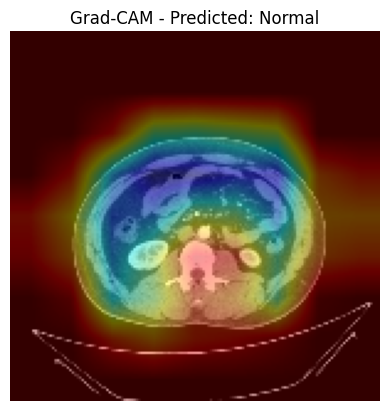

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


AttributeError: The layer sequential has never been called and thus has no defined output.

In [ ]:
indices = [5, 15, 25, 40]  # Pick random indexes from validation set

for idx in indices:
    img_rgb = X_val[idx][:,:,:3]
    img_full = X_val[idx]

    # VGG16 Grad-CAM
    pred = model_vgg.predict(np.expand_dims(img_rgb, axis=0))
    pred_label = np.argmax(pred)
    display_gradcam(img_rgb, pred_label, model_vgg, last_conv_layer='block5_conv3')

    # CNN Grad-CAM
    pred = model_cnn.predict(np.expand_dims(img_full, axis=0))
    pred_label = np.argmax(pred)
    display_gradcam(img_full, pred_label, model_cnn, last_conv_layer='conv2d_5')  # adjust layer if needed

In [ ]:
# Re-run the prediction cell for VGG16 to define y_pred_prob
y_pred_prob = model_vgg.predict(X_val[:,:,:,:3])

6/6 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step
